Task 1

In [27]:
import numpy as np
import matplotlib.pyplot as plt

In [28]:
# Transition matrix P
P = np.array([[0.9915, 0.005, 0.0025, 0, 0.001],[0, 0.986, 0.005, 0.004, 0.005],[0, 0, 0.992, 0.003, 0.005],
             [0, 0, 0, 0.991, 0.009], [0,0,0,0,1]])

In [29]:
def MMC_simulation(transition_prob, initial_stat_prob = [1, 0, 0, 0, 0]):

    N_states = len(initial_stat_prob)
    current_state = []
    # all start at state 1
    current_state.append(np.random.choice(N_states, p=initial_stat_prob))
    month = 0
    while True:

        next_state = np.random.choice(N_states, p=transition_prob[current_state[-1], : ].reshape(-1))

        current_state.append(next_state)
        next_state = current_state[-1]

        month = month + 1


        if current_state[-1] == 4:
            break

    return current_state, month

In [30]:
def simulate_multiple_MMC(n_simulation, transition_prob, initial_stat_prob = [1, 0, 0, 0, 0]):

    months = []
    current_states = []
    for sim in range(n_simulation):

        current_state, month = MMC_simulation(transition_prob, initial_stat_prob)
        months.append(month)

        current_states.append(current_state)


    # plt.hist(months, bins=int(len(months) / 10), edgecolor='black')
    # plt.xlabel('Months until death')
    # plt.ylabel('Frequency')
    # plt.title('Histogram of months until death')
    # plt.show()

    return current_states, months

In [31]:
n_simulation = 1000
current_states, months = simulate_multiple_MMC(n_simulation, P)


In [32]:
import copy

# Find the maximum length among all state trajectories
max_len = max(len(seq) for seq in current_states)

# Pad each sequence with zeros to make all sequences the same length
current_states_matrix = np.array([seq + [0] * (max_len - len(seq)) for seq in current_states])
current_states_matrix_ = copy.deepcopy(current_states_matrix)

cancer_reapp_mask = np.any(np.isin(current_states_matrix,[1,3]), axis=1)

prop_canc_reapp = np.sum(cancer_reapp_mask) / n_simulation
print(prop_canc_reapp)

0.68


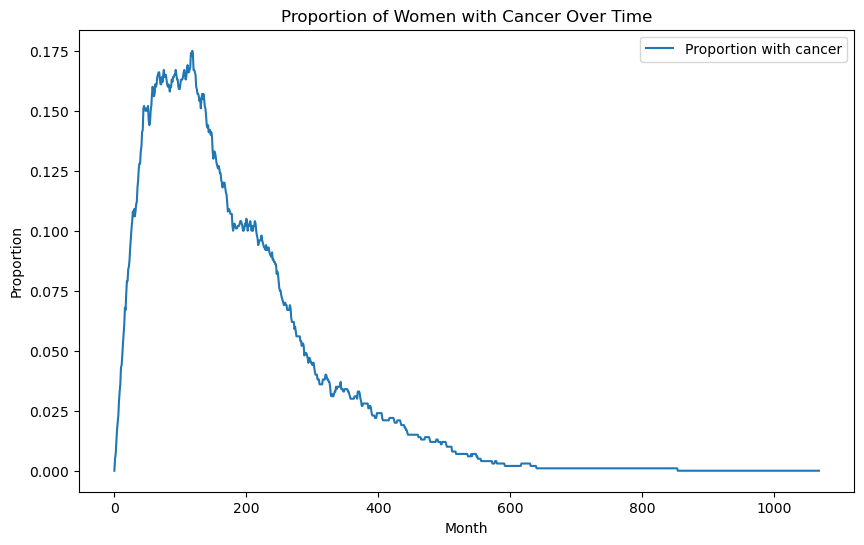

In [33]:
import copy

# Find the maximum length among all state trajectories
max_len = max(len(seq) for seq in current_states)

# Pad each sequence with zeros to make all sequences the same length
current_states_matrix = np.array([seq + [0] * (max_len - len(seq)) for seq in current_states])

current_states_matrix_ = copy.deepcopy(current_states_matrix)

current_states_matrix_[np.isin(current_states_matrix, [1])] = 1
current_states_matrix_[np.isin(current_states_matrix, [0, 2, 3, 4])] = 0

n_women_cancer = np.sum(current_states_matrix_, axis=0)

prop = n_women_cancer / 1000

plt.figure(figsize=(10, 6))
plt.plot(range(len(prop)), prop, label='Proportion with cancer')
plt.xlabel('Month')
plt.ylabel('Proportion')
plt.title('Proportion of Women with Cancer Over Time')
plt.legend()
plt.show()

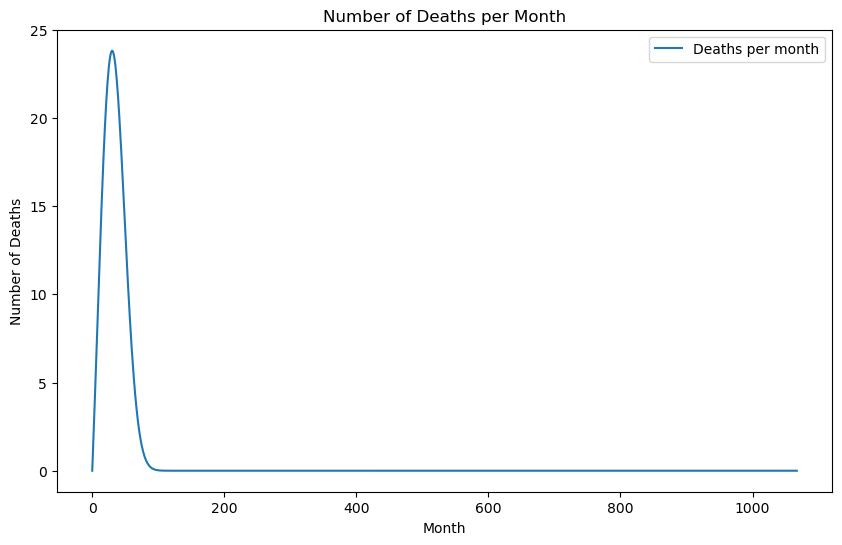

In [34]:
initial_stat_prob = [1, 0, 0, 0, 0]
p_t = np.array([initial_stat_prob @ np.linalg.matrix_power(P, t) for t in range(np.max(months))])

p_death = p_t[:, -1]
n_woman = 1000

deaths = []
for t in range(len(p_death)):

    deaths.append(n_woman * p_death[t])

    n_woman = n_woman - deaths[-1]

plt.figure(figsize=(10, 6))
plt.plot(range(len(deaths)), deaths, label='Deaths per month')
plt.xlabel('Month')
plt.ylabel('Number of Deaths')
plt.title('Number of Deaths per Month')
plt.legend()
plt.show()

Task 2

In [35]:
t = 120
possible_states = np.array([0, 1, 2, 3, 4])
n_woman = 1000

max_len = max(len(seq) for seq in current_states)

current_states_matrix = np.array([seq + [4] * (max_len - len(seq)) for seq in current_states])

states = [np.sum(current_states_matrix[:, t] == state) for state in possible_states]
prob_120 = np.array(states) / n_woman
freq_emp = np.array(states)

print(freq_emp)
print(prob_120)

prob_theor_120 = p_t[t, :]
freq_exp = np.round(prob_theor_120 * n_woman)
print(freq_exp)

print(prob_theor_120)

[356 167 155  66 256]
[0.356 0.167 0.155 0.066 0.256]
[359. 159. 166.  68. 248.]
[0.35902627 0.15895604 0.1660869  0.06774149 0.2481893 ]


In [36]:
from scipy.stats import chisquare

chi2_stat, p_value = chisquare(f_obs=freq_emp, f_exp=freq_exp)
print(f"Chi2 stat: {chi2_stat:.4f}, p-value: {p_value:.4f}")

Chi2 stat: 1.4734, p-value: 0.8313


Task 3

In [37]:
Ps = P[: -1, : -1]
ps = P[: -1, -1]

discrete_phase_distribution = np.array([initial_stat_prob[: -1] @ np.linalg.matrix_power(Ps, t) @ ps for t in range(np.max(months))])

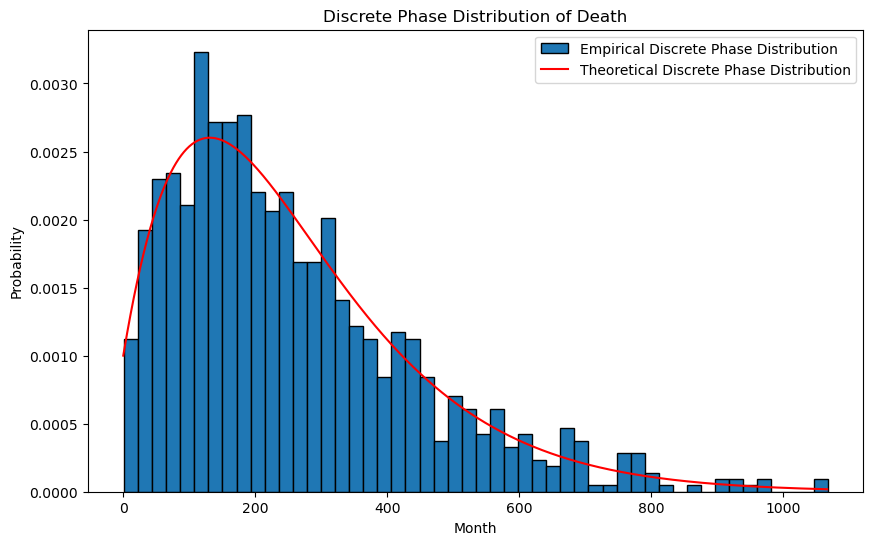

In [38]:
discrete_phase_distribution_emp = np.where((current_states_matrix[:, 1:] == 4) & (current_states_matrix[:, :-1] != 4))[1] + 1

plt.figure(figsize=(10, 6))
plt.hist(discrete_phase_distribution_emp, bins=50, edgecolor='black', density=True, label='Empirical Discrete Phase Distribution')
plt.xlabel('Month')
plt.ylabel('Probability')
plt.plot(discrete_phase_distribution, label='Theoretical Discrete Phase Distribution', color = 'red')
plt.title('Discrete Phase Distribution of Death')
plt.legend()
plt.show()


In [39]:
emp_expected_value = np.mean(discrete_phase_distribution_emp)
print(emp_expected_value)

theor_expected_value = initial_stat_prob[: -1] @ np.linalg.inv((np.eye(Ps.shape[0]) - Ps)) @ np.ones(Ps.shape[0])
print(theor_expected_value)


259.472
262.3716153127931


Task 4

In [40]:
n = 0
total_month = []
while n < 1000:

    current_states, months = MMC_simulation(P, initial_stat_prob = [1, 0, 0, 0, 0])
    
    if (months > 12) and np.any(np.isin(current_states_matrix[:11], [1, 2, 3])):
        total_month.append(months)
        n += 1
total_month = np.array(total_month)




264.559


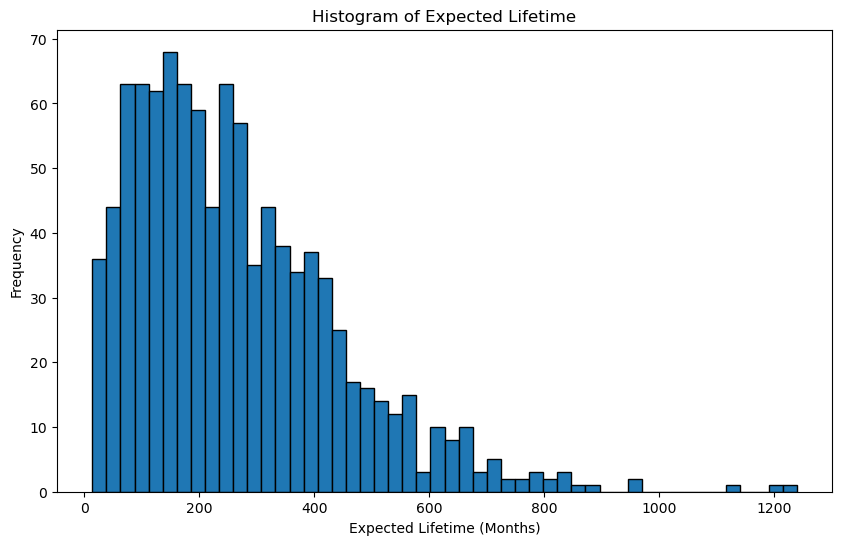

In [41]:
expected_lifetime = np.mean(total_month)
print(expected_lifetime)

plt.figure(figsize=(10, 6))
plt.hist(total_month, bins=50, edgecolor='black')
plt.xlabel('Expected Lifetime (Months)')
plt.ylabel('Frequency')
plt.title('Histogram of Expected Lifetime')
plt.show()

Task 5

In [ ]:
n_women = 200
n_sim = 100
fraction = []
mean_lifetime = []
lim = 350

for sim in range(n_sim):

    current_states, months = simulate_multiple_MMC(n_women, P)

    fraction.append(np.sum(np.array(months) <= lim) / n_women)
    mean_lifetime.append(np.mean(months))

fraction = np.array(fraction)
mean_lifetime = np.array(mean_lifetime)

In [ ]:
MC_ext = np.mean(fraction)
MC_var = np.var(fraction, ddof = 1)
print(f"Estimated mean fraction (MC_ext): {MC_ext}")
print(f"Sample variance of fraction (MC_var): {MC_var}")


Estimated mean fraction (MC_ext): 0.7357
Sample variance of fraction (MC_var): 0.001057585858585859


In [ ]:
print(fraction.shape)
print(mean_lifetime.shape)

(100,)
(100,)


In [ ]:
c = -np.cov(fraction, mean_lifetime)[0, 1] / np.var(mean_lifetime, ddof = 1)

Z = fraction + c * (mean_lifetime - np.mean(mean_lifetime))

CV_ext = np.mean(Z)
CV_var = np.var(Z, ddof = 1)
print(f"Estimated mean fraction (CV_ext): {CV_ext}")
print(f"Sample variance of fraction (CV_var): {CV_var}")

Estimated mean fraction (CV_ext): 0.7356999999999999
Sample variance of fraction (CV_var): 0.0004345736019119149
